In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import gym
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
ENV_NAME = "LunarLander-v2"
GAMMA = 0.999
LAMBDA = 0.95
LR = 1e-4
MAX_EPISODES = 20000
NUM_WORKERS = 4
ENTROPY_BETA = 0.01
GRAD_CLIP = 0.5
torch.manual_seed(0)

In [2]:
class ActorCritic(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.policy = nn.Linear(128, output_dim)
        self.value = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.policy(x), self.value(x)

In [3]:
class Worker(mp.Process):
    def __init__(self, gnet, optimizer, global_ep, res_queue, name):
        super(Worker, self).__init__()
        self.name = f"worker_{name}"
        self.gnet = gnet
        self.optimizer = optimizer
        self.global_ep = global_ep
        self.res_queue = res_queue
        self.env = gym.make(ENV_NAME)
        self.local_net = ActorCritic(self.env.observation_space.shape[0], self.env.action_space.n)

    def compute_gae(self, rewards, values, next_value, dones):
        values = values + [next_value]
        gae = 0
        returns = []
        for step in reversed(range(len(rewards))):
            delta = rewards[step] + GAMMA * values[step + 1] * (1 - dones[step]) - values[step]
            gae = delta + GAMMA * LAMBDA * (1 - dones[step]) * gae
            returns.insert(0, gae + values[step])
        return returns

    def run(self):
        while self.global_ep.value < MAX_EPISODES:
            self.local_net.load_state_dict(self.gnet.state_dict())
            state = self.env.reset()
            if isinstance(state, tuple):
                state = state[0]

            log_probs, values, rewards, entropies, dones = [], [], [], [], []
            done, ep_reward = False, 0

            while not done:
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                logits, value = self.local_net(state_tensor)
                probs = F.softmax(logits, dim=-1)
                dist = torch.distributions.Categorical(probs)
                action = dist.sample()

                step_result = self.env.step(action.item())
                if len(step_result) == 5:
                    next_state, reward, terminated, truncated, _ = step_result
                    done = terminated or truncated
                else:
                    next_state, reward, done, _ = step_result

                reward = np.clip(reward, -1, 1)
                log_probs.append(dist.log_prob(action))
                entropies.append(dist.entropy())
                values.append(value.squeeze(0))
                rewards.append(reward)
                dones.append(done)

                state = next_state
                ep_reward += reward

            with torch.no_grad():
                next_state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                _, next_value = self.local_net(next_state_tensor)
                next_value = next_value.item()

            returns = self.compute_gae(rewards, values, next_value, dones)
            returns = torch.tensor(returns, dtype=torch.float32)
            values = torch.stack(values)
            log_probs = torch.stack(log_probs)
            entropies = torch.stack(entropies)

            advantage = returns - values
            advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-5)

            actor_loss = -(log_probs * advantage.detach()).mean()
            critic_loss = advantage.pow(2).mean()
            entropy_loss = entropies.mean()
            total_loss = actor_loss + critic_loss - ENTROPY_BETA * entropy_loss

            self.optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.local_net.parameters(), GRAD_CLIP)

            for lp, gp in zip(self.local_net.parameters(), self.gnet.parameters()):
                if gp.grad is None:
                    gp._grad = lp.grad.clone()
                else:
                    gp._grad += lp.grad

            self.optimizer.step()

            with self.global_ep.get_lock():
                self.global_ep.value += 1

            self.res_queue.put((self.name, ep_reward))

[worker_3] Episode 10 | Reward: -16.75
[worker_2] Episode 20 | Reward: -44.35
[worker_0] Episode 30 | Reward: -35.85
[worker_1] Episode 40 | Reward: -57.84
[worker_0] Episode 50 | Reward: -47.32
[worker_3] Episode 60 | Reward: -7.25
[worker_0] Episode 70 | Reward: -87.98
[worker_1] Episode 80 | Reward: -47.48
[worker_0] Episode 90 | Reward: -17.15
[worker_3] Episode 100 | Reward: -54.14
[worker_0] Episode 110 | Reward: -38.78
[worker_3] Episode 120 | Reward: -4.49
[worker_2] Episode 130 | Reward: -37.88
[worker_0] Episode 140 | Reward: -45.87
[worker_1] Episode 150 | Reward: -34.29
[worker_2] Episode 160 | Reward: -46.31
[worker_3] Episode 170 | Reward: -21.88
[worker_3] Episode 180 | Reward: -27.99
[worker_3] Episode 190 | Reward: -77.64
[worker_1] Episode 200 | Reward: -3.52
[worker_3] Episode 210 | Reward: -20.79
[worker_0] Episode 220 | Reward: -13.71
[worker_1] Episode 230 | Reward: -56.20
[worker_0] Episode 240 | Reward: -51.67
[worker_0] Episode 250 | Reward: -82.56
[worker_2] E

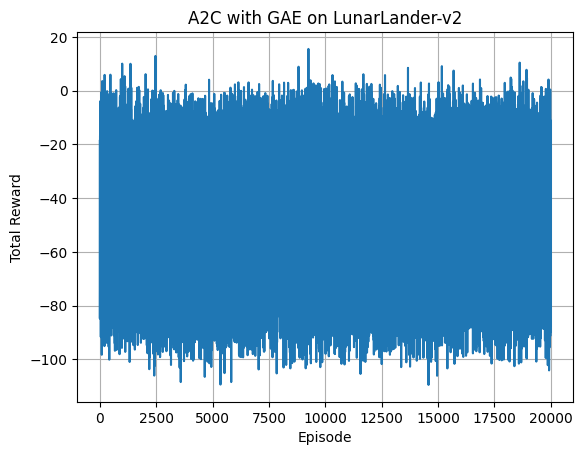

In [ ]:
def train():
    env = gym.make(ENV_NAME)
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    env.close()

    global_net = ActorCritic(input_dim, output_dim)
    global_net.share_memory()
    optimizer = torch.optim.Adam(global_net.parameters(), lr=LR)

    global_ep = mp.Value('i', 0)
    res_queue = mp.Queue()

    workers = [Worker(global_net, optimizer, global_ep, res_queue, i) for i in range(NUM_WORKERS)]
    for w in workers:
        w.start()

    rewards = []
    best_reward = float('-inf')
    best_weights = None

    while True:
        name, reward = res_queue.get()
        rewards.append(reward)
        ep_num = len(rewards)
        if ep_num % 10 == 0:
            print(f"[{name}] Episode {ep_num} | Reward: {reward:.2f}")

        if reward > best_reward:
            best_reward = reward
            best_weights = global_net.state_dict()

        if global_ep.value >= MAX_EPISODES:
            break

    for w in workers:
        w.join()

    if best_weights:
        torch.save(best_weights, "a2c_best_lunarlander.pth")
        print(f"\nSaved best model with reward {best_reward:.2f}")

    global_net.load_state_dict(torch.load("a2c_best_lunarlander.pth"))
    return rewards, global_net

def evaluate(model, episodes=10, render=False):
    env = gym.make(ENV_NAME)
    model.eval()
    total_rewards = []

    for ep in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]

        done, ep_reward = False, 0
        while not done:
            if render:
                env.render()
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            logits, _ = model(state_tensor)
            action = torch.argmax(F.softmax(logits, dim=-1)).item()
            step_result = env.step(action)
            if len(step_result) == 5:
                state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            else:
                state, reward, done, _ = step_result
            ep_reward += reward
        print(f"Evaluation Episode {ep + 1}: Reward = {ep_reward:.2f}")
        total_rewards.append(ep_reward)

    env.close()
    avg = np.mean(total_rewards)
    std = np.std(total_rewards)
    print(f"\nAverage Reward over {episodes} episodes: {avg:.2f} ± {std:.2f}")
    return total_rewards

if __name__ == "__main__":
    rewards, model = train()
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("A2C with GAE on LunarLander-v2")
    plt.grid()
    plt.show()

In [ ]:
print("\nRunning Evaluation...")
env = gym.make(ENV_NAME)
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
env.close()
best_model = ActorCritic(input_dim, output_dim)
best_model.load_state_dict(torch.load("a2c_best_lunarlander.pth"))
eval_rewards=evaluate(best_model, episodes=10, render=False)


Running Evaluation...
Evaluation Episode 1: Reward = -494.74
Evaluation Episode 2: Reward = -487.33
Evaluation Episode 3: Reward = -676.74
Evaluation Episode 4: Reward = -501.35
Evaluation Episode 5: Reward = -529.49
Evaluation Episode 6: Reward = -494.79
Evaluation Episode 7: Reward = -627.75
Evaluation Episode 8: Reward = -656.33
Evaluation Episode 9: Reward = -257.84
Evaluation Episode 10: Reward = -564.51

Average Reward over 10 episodes: -529.09 ± 112.88


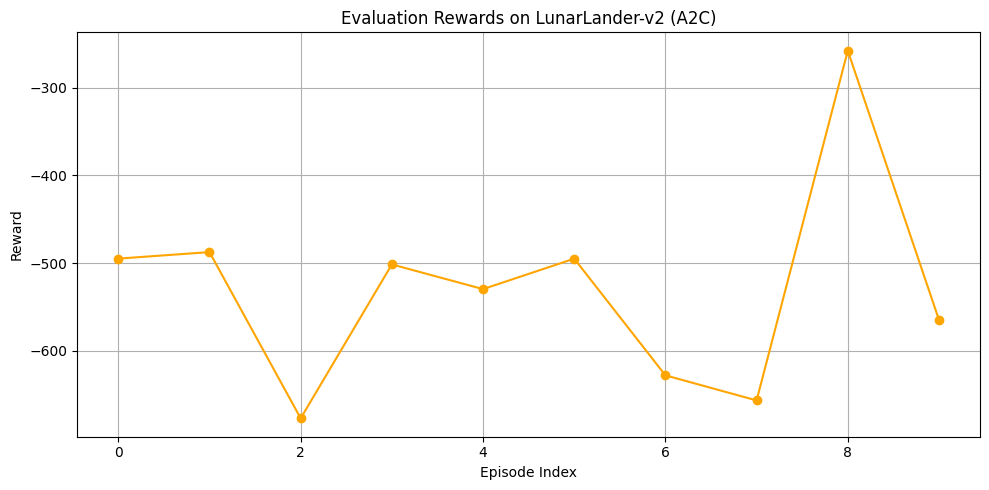

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(eval_rewards, marker='o', color='orange')
plt.title("Evaluation Rewards on LunarLander-v2 (A2C)")
plt.xlabel("Episode Index")
plt.ylabel("Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
pip install numpy==1.24.4

In [14]:
!apt-get update && apt-get install -y swig


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,607 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,696 kB]
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [4,118 kB]
Hit:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:13 http://archive.ubuntu.co

In [15]:
!pip install box2d-py==2.3.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2351174 sha256=57d53cc6bd6995eda94eca5645fc609836a58b5f067feca0559905bed3ebf6b2
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [16]:
!python -c "import Box2D; print('Box2D imported successfully')"


Box2D imported successfully
